# Ramp 20 Variances + Means

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame
    
def generate_data_0(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].abs().rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    #data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    #data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = ["SD"]
    
    assert data[select_list].to_numpy()[window-1::step].shape[0] == data['time'].to_numpy()[window-1::step].shape[0]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1::step], data['time'].to_numpy()[window-1::step]

def generate_data_no_time(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the statistics
    #data["Mean"] = data.loc[:, channel].abs().rolling(window=window).mean()
    data["SD"] = data.loc[:, channel].rolling(window=window).std()
    #data["Kurtosis"] = data.loc[:, channel].rolling(window=window).kurt()
    #data["Skew"] = data.loc[:, channel].rolling(window=window).skew()
    
    select_list = ["SD"]
    
    %reset -f in
    
    return data[select_list].to_numpy()[window-1::step]

def generate_data_all_sensors(dir_path, time_range, window = 1000, step = 10):
    
    ai0, time = generate_data(dir_path, "ai0", time_range = time_range, window = window, step = step)
    ai1 = generate_data_no_time(dir_path, "ai1", time_range = time_range, window = window, step = step)
    ai2 = generate_data_no_time(dir_path, "ai2", time_range = time_range, window = window, step = step)
    ai3 = generate_data_no_time(dir_path, "ai3", time_range = time_range, window = window, step = step)
    ai4 = generate_data_no_time(dir_path, "ai4", time_range = time_range, window = window, step = step)
    
    #Multiply them all together
    product_var = ai0*ai1*ai2*ai3*ai4
    
    
    all_channels = np.concatenate((ai0,ai1,ai2,ai3,ai4,product_var), axis = 1)
    
    %reset -f in
    
    return all_channels, time

def plot_moving_mean(dir_path, channel, time_range, window = 1000, step = 10):
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the mean
    data["Mean"] = data.loc[:, channel].abs().rolling(window=window).mean()
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(data['time'].to_numpy()[window-1::step], data["Mean"].to_numpy()[window-1::step], label = "Mean of abs(data)")
    plt.legend(loc = "upper right")
    plt.xlabel("Time (s)")
    plt.title("Sensor {}'s moving mean".format(channel))
    
    %reset -f in
    
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data
    
def plot_product_mean(dir_path, time_range, window = 1000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    time_axis = ai0['time'].to_numpy()[window-1::step]
    
    ai0 = ai0["ai0"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product)
    plt.xlabel("Time (s)")
    plt.title("Product of moving means")
    
def plot_SD(dir_path, channel, time_range, window = 2000, step = 10):
    
    #Load the data
    data = load_channel_and_time(dir_path, channel)
    
    #Select the part
    start = time_range[0]
    end = time_range[1]
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Calculate the mean
    data["SD"] = data.loc[:, channel].abs().rolling(window=window).std()
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(data['time'].to_numpy()[window-1::step], data["SD"].to_numpy()[window-1::step], label = "Standard deviation", color = "red")
    plt.legend(loc = "upper right")
    plt.xlabel("Time (s)")
    plt.title("Sensor {}'s moving standard deviation".format(channel))
    
    %reset -f in


def plot_product_SD(dir_path, time_range, window = 1000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].rolling(window=window).std().to_numpy()[window-1::step]
    
    time_axis = ai0['time'].to_numpy()[window-1::step]
    
    ai0 = ai0["ai0"].rolling(window=window).std().to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product, color = "red")
    plt.xlabel("Time (s)")
    plt.title("Product of moving standard deviations")
    
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)["ai0"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range)["ai0"].rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range)["ai1"].rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range)["ai2"].rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range)["ai3"].rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range)["ai4"].rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label
    

def generate_data(dir_path, time_range, window = 2000, step = 10):
    
    moving_mean = generate_mean_data(dir_path, time_range, window = 2000, step = 10)
    moving_sd = generate_sd_data(dir_path, time_range, window = 2000, step = 10)
    time_label = load_time_label(dir_path, time_range, window = 2000, step = 10)
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

## 1. Try traditional method

In [3]:
X_train, train_time = generate_data("./data/Ramp20/", time_range = (-450, -350), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp20/", time_range = (-50, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history


KeyboardInterrupt: 

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [9]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                84        
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 400738 samples, validate on 44527 samples
Epoch 1/50
400738/400738 [==============================] - 3s 8us/step - loss: 6.8568e-04 - val_loss: 0.0020
Epoch 2/50
400738/400738 [==============================] - 1s 4us/step - loss: 1.5446e-04 - val_loss: 0.0015
Epoch 3/50
400738/400738 [==============================] - 2s 4us/step - loss: 1.0393e-04 - val_loss: 0.0013
Epoch 4/50
400738/400738 [==============================] - 2s 4us/step - loss: 7.4612e-05 - val_loss: 0.0012
Epoch 5/50
400738/400738 [==============================] - 2s 5us/step - loss: 6.5107e-05 - val_loss: 0.0013
Epoch 6/50
400738/400738 [==============================] - 2s 5us/step - loss: 6.2110e-05 - val_loss: 0.0013
Epoch 7/50
400738/400738 [==============================] - 2s 4us/step - loss: 6.0485e-05 - val_loss: 0.0013
Epoch 8/50
400738/400738 [==============================] - 2s 5us/step - loss: 5.9384e-05 - val_loss: 0.0013
Epoch 9/50
400738/400738 [==============================] - 2s 4us/st

In [11]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [12]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

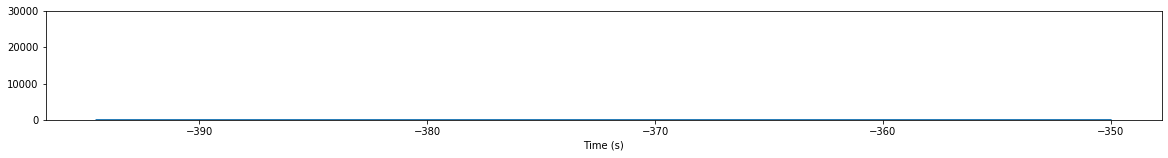

In [20]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 30000])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

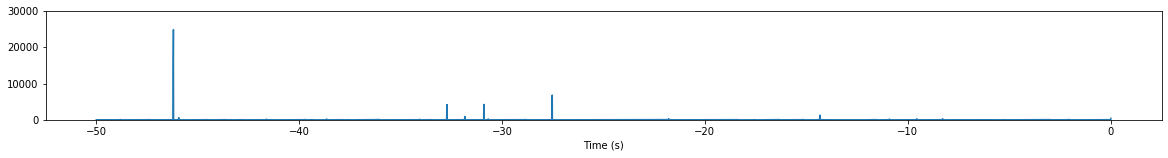

In [19]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 30000])
#plt.xlim([-1,0])
plt.xlabel("Time (s)")

### 1.2 Try another testing range (-200, -50)

In [3]:
X_train, train_time = generate_data("./data/Ramp20/", time_range = (-450, -350), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp20/", time_range = (-200, -50), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (445265, 12)
X_test's shape:  (1499800, 12)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                84        
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 400738 samples, validate on 44527 samples
Epoch 1/50
400738/400738 [==============================] - 2s 6us/step - loss: 7.7620e-04 - val_loss: 0.0020
Epoch 2/50
400738/400738 [==============================] - 2s 4us/step - loss: 1.3462e-04 - val_loss: 0.0017
Epoch 3/50
400738/400738 [==============================] - 2s 4us/step - loss: 8.0010e-05 - val_loss: 0.0016
Epoch 4/50
400738/400738 [==============================] - 1s 3us/step - loss: 6.9037e-05 - val_loss: 0.0016
Epoch 5/50
400738/400738 [==============================] - 1s 3us/step - loss: 6.5867e-05 - val_loss: 0.0017
Epoch 6/50
400738/400738 [==============================] - 2s 4us/step - loss: 6.3932e-05 - val_loss: 0.0017
Epoch 7/50
400738/400738 [==============================] - 2s 4us/step - loss: 6.2516e-05 - val_loss: 0.0018
Epoch 8/50
400738/400738 [==============================] - 2s 4us/step - loss: 6.1389e-05 - val_loss: 0.0017
Epoch 9/50
400738/400738 [==============================] - 2s 4us/st

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

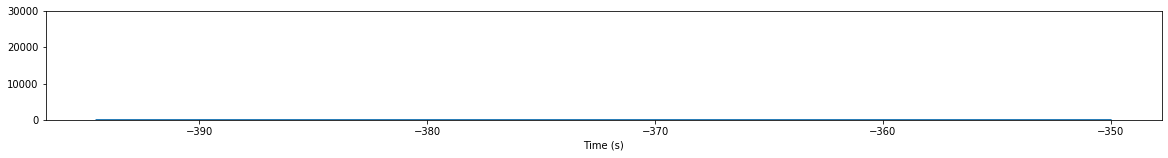

In [11]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 30000])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

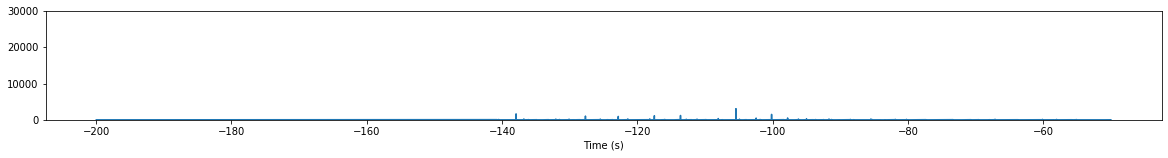

In [12]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 30000])
#plt.xlim([-1,0])
plt.xlabel("Time (s)")

### 1.3 Testing range (-350, -200)

In [3]:
X_train, train_time = generate_data("./data/Ramp20/", time_range = (-450, -350), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp20/", time_range = (-350, -200), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (445265, 12)
X_test's shape:  (1499800, 12)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                84        
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 400738 samples, validate on 44527 samples
Epoch 1/50
400738/400738 [==============================] - 3s 7us/step - loss: 6.9400e-04 - val_loss: 0.0020
Epoch 2/50
400738/400738 [==============================] - 2s 5us/step - loss: 1.4554e-04 - val_loss: 0.0018
Epoch 3/50
400738/400738 [==============================] - 2s 5us/step - loss: 1.2605e-04 - val_loss: 0.0018
Epoch 4/50
400738/400738 [==============================] - 2s 6us/step - loss: 1.0623e-04 - val_loss: 0.0019
Epoch 5/50
400738/400738 [==============================] - 2s 5us/step - loss: 8.4887e-05 - val_loss: 0.0018
Epoch 6/50
400738/400738 [==============================] - 2s 5us/step - loss: 6.9606e-05 - val_loss: 0.0017
Epoch 7/50
400738/400738 [==============================] - 2s 5us/step - loss: 6.2451e-05 - val_loss: 0.0015
Epoch 8/50
400738/400738 [==============================] - 2s 4us/step - loss: 6.0286e-05 - val_loss: 0.0014
Epoch 9/50
400738/400738 [==============================] - 2s 5us/st

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

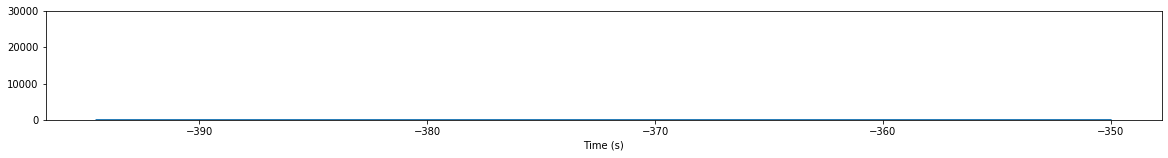

In [9]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 30000])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

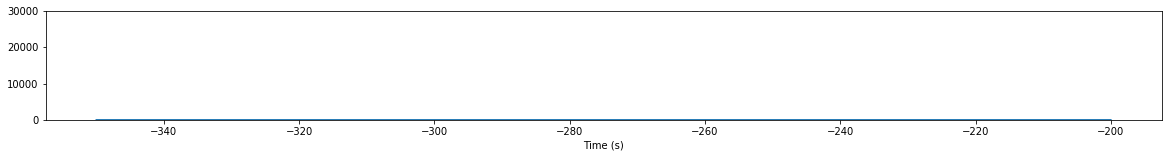

In [10]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 30000])
#plt.xlim([-1,0])
plt.xlabel("Time (s)")

## 2. Try starts learning after previous current's reached

In [3]:
X_train, train_time = generate_data("./data/Ramp20/", time_range = (-140, -70), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp20/", time_range = (-70, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (699800, 12)
X_test's shape:  (699800, 12)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                84        
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 629820 samples, validate on 69980 samples
Epoch 1/50
629820/629820 [==============================] - 4s 7us/step - loss: 0.0011 - val_loss: 4.0352e-04
Epoch 2/50
629820/629820 [==============================] - 3s 6us/step - loss: 3.8201e-04 - val_loss: 2.6887e-04
Epoch 3/50
629820/629820 [==============================] - 3s 5us/step - loss: 2.7616e-04 - val_loss: 1.9389e-04
Epoch 4/50
629820/629820 [==============================] - 3s 5us/step - loss: 2.2176e-04 - val_loss: 1.6769e-04
Epoch 5/50
629820/629820 [==============================] - 3s 5us/step - loss: 2.0260e-04 - val_loss: 1.6331e-04
Epoch 6/50
629820/629820 [==============================] - 3s 5us/step - loss: 1.9550e-04 - val_loss: 1.6205e-04
Epoch 7/50
629820/629820 [==============================] - 3s 5us/step - loss: 1.9145e-04 - val_loss: 1.6279e-04
Epoch 8/50
629820/629820 [==============================] - 3s 5us/step - loss: 1.8881e-04 - val_loss: 1.6199e-04
Epoch 9/50
629820/629820 [===============

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

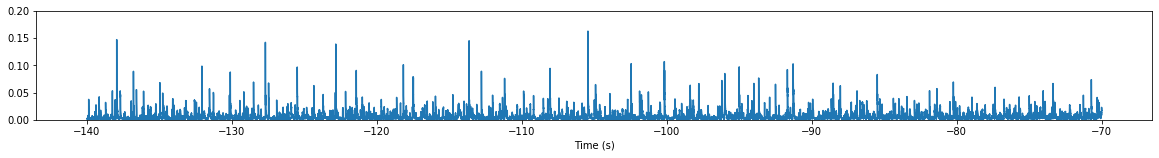

In [13]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 0.2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

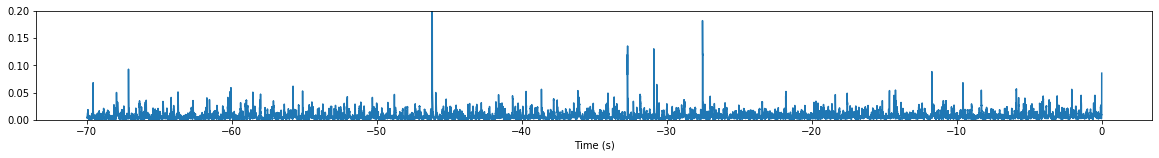

In [14]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 0.2])
#plt.xlim([-1,0])
plt.xlabel("Time (s)")

## 3. try start learning until operating current

In [3]:
X_train, train_time = generate_data("./data/Ramp20/", time_range = (-300, -18), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp20/", time_range = (-18, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (2819800, 12)
X_test's shape:  (179800, 12)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(3,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                84        
Total params: 207
Trainable params: 207
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 2537820 samples, validate on 281980 samples
Epoch 1/50
2537820/2537820 [==============================] - 13s 5us/step - loss: 1.6422e-04 - val_loss: 3.1075e-04
Epoch 2/50
2537820/2537820 [==============================] - 13s 5us/step - loss: 7.2277e-05 - val_loss: 3.0065e-04
Epoch 3/50
2537820/2537820 [==============================] - 12s 5us/step - loss: 6.5998e-05 - val_loss: 2.6397e-04
Epoch 4/50
2537820/2537820 [==============================] - 13s 5us/step - loss: 6.0840e-05 - val_loss: 2.4232e-04
Epoch 5/50
2537820/2537820 [==============================] - 12s 5us/step - loss: 5.4677e-05 - val_loss: 2.2267e-04
Epoch 6/50
2537820/2537820 [==============================] - 12s 5us/step - loss: 5.1373e-05 - val_loss: 2.1738e-04
Epoch 7/50
2537820/2537820 [==============================] - 13s 5us/step - loss: 4.9895e-05 - val_loss: 2.1365e-04
Epoch 8/50
2537820/2537820 [==============================] - 13s 5us/step - loss: 4.8987e-05 - val_loss: 2.1504e-04
Epoch 9/50


In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

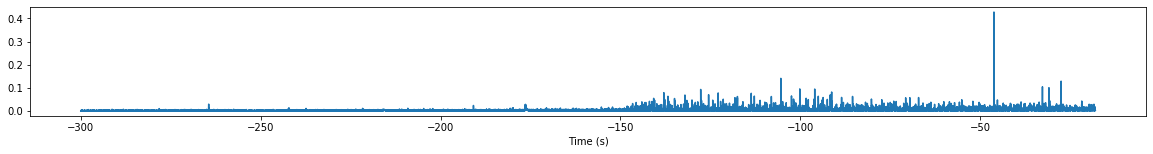

In [11]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
#plt.ylim([0, 0.2])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

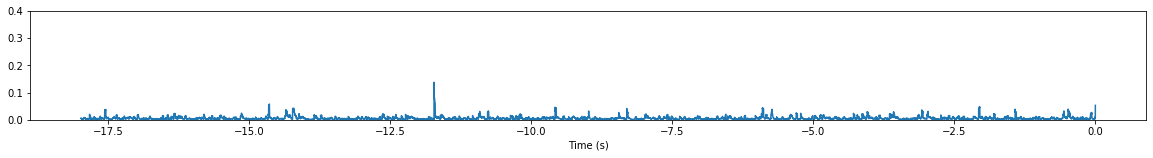

In [12]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 0.4])
#plt.xlim([-1,0])
plt.xlabel("Time (s)")